# I. Overview

Describe the objective of this assignment. You can briefly state how you accompilsh it.

# II. Maze Problem

Describe the problem. Read the following code and explain the GridWorld environment. 

In [1]:
import math
import collections
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

np.random.seed(1)

## Sample Grid Environment File

Simple text file with three characters, 'O', 'H', and 'G'.
- 'O': open space
- 'H': Wall or obstacles
- 'G': Goal location 

In [2]:
file = open("grid.txt", "r")
data = file.read()
print(data)

OOOHOOOOO
OOOHOOHOO
OOOOOOHOO
OOOOHHHOO
OOHOOOOOH
OOHOOGOOO
OOOOOOOOO


In [3]:
# maze example

debug = False
verbose = False


class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up
            
            my change
            ---------
            
            print env.next(0)  # left
            print env.next(1)  # right
            print env.next(2)  # up
            print env.next(3)  # down

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def set_cur_state(self,s):
        self._s=s
    
    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )
    
    def get_map(self):
        return self._map 
        
    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state
            
        if self.check_state(s) == 'O':
            #self._s = np.asarray(state)
            self._s = np.asarray(s)
        else:
            raise ValueError("Invalid state for init")
        

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    #Method to check if the current state is a goal state
    def goal_reached(self):
        if(self._s is not None and self._s[0]==self.goal_pos[0] and self._s[1]==self.goal_pos[1]):
            return True
        else:
            return False
    
    #Method to check if a state is a goal state
    def is_goal(self,s):
        if(s is not None and s[0]==self.goal_pos[0] and s[1]==self.goal_pos[1]):
            return True
        else:
            return False
        
    def get_actions(self):
        return self._actions

In [4]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'G' 'O' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


# III. Methods

In [5]:
#This method will return true only with a given probaility 
import random
def selectRandomAction(epsilon):
    return random.random()<epsilon

#Method to choose action from a state s using the estimated Q values wit epsilon-greedy
def epsilon_greedy_action(QValues,epsilon=0.01):
    greedy_action=None
    
    maxQ=np.max(QValues)
    
    eqaualMax=np.where(QValues == maxQ)[1]
    action=np.random.choice(eqaualMax)
    
    if(selectRandomAction(epsilon)):
        random_action=np.random.randint(4)
        action=random_action
        maxQ=QValues[0,action]
    
    return maxQ,action

### Learning Model

In [6]:
#import the keras library
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [7]:
class NNModel:
    def __init__(self):
        no_of_input_nodes=2
        no_of_hl1_nodes=20
        no_of_hl2_nodes=20
        no_of_hl3_nodes=10
        no_of_output_nodes=4
        
        self.model=Sequential([
            Dense(input_dim=no_of_input_nodes,units=no_of_hl1_nodes,activation="relu"),
            Dense(input_dim=no_of_hl1_nodes,units=no_of_hl2_nodes,activation="relu"),
            Dense(input_dim=no_of_hl2_nodes,units=no_of_hl3_nodes,activation="relu"),
            Dense(input_dim=no_of_hl3_nodes,units=no_of_output_nodes)
        ])
        self.model.compile(loss='mean_squared_error',optimizer='adam')
        
    def train(self,state,Qvalues):
        X=state.copy()
        Y=Qvalues.copy()
        X[0,0]=X[0,0]+1
        X[0,1]=X[0,1]+1
        self.model.fit(X,Y,verbose=False)
        
    def predict(self,state):
        X=state.copy()
        X[0,0]=X[0,0]+1
        X[0,1]=X[0,1]+1
        return self.model.predict(X)

### Neural Network learning

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
#A method to learn best way to find the goal
def learn_find_goal(env,learning_model,epsilon,gamma,epoch):
    steps=1;
    states=[]
    total_reward=0
    current_state=env.get_cur_state()
    X=np.asarray(current_state).reshape((1,2))
    current_state_actions_QValues=learning_model.predict(X)
    current_state_maxQ,current_state_a=epsilon_greedy_action(current_state_actions_QValues)
    #Add the current state to the path
    while(not env.goal_reached()):
        states.append(current_state)
        reward=env.next(current_state_a)
        next_state=env.get_cur_state()
        
        #if the next state is the goal state
        X_next_state=np.asarray(next_state).reshape((1,2))
        #get the Q values for the next state action pairs
        next_state_actions_QValues=learning_model.predict(X_next_state)
        next_state_maxQ,next_state_a=epsilon_greedy_action(next_state_actions_QValues)
        
        #print(current_state,"\t",current_state_a,"\t",reward,"\t",next_state,"\t",next_state_a,"\t",
        #      current_state_actions_QValues,"\t",next_state_actions_QValues)
        
        if(env.is_goal(next_state)):
            next_state_maxQ=0
            
        true_Q=reward+gamma*next_state_maxQ
        #update the current state q values for this action to train neural network
        current_state_actions_QValues[0,current_state_a]=true_Q
        
        X_current_state=np.asarray(current_state).reshape((1,2))
        Y_current_state=np.asarray(current_state_actions_QValues).reshape((1,4))
        #fit the model using this new Q value for the current state
        learning_model.train(X_current_state,Y_current_state)
        
        #update the state action pair and Q values of the next state actions
        current_state=next_state
        current_state_a=next_state_a
        current_state_actions_QValues=learning_model.predict(X_next_state)
        
        total_reward+=reward
        steps=steps+1
        
    #train for the goal state
    X_current_state=np.asarray(current_state).reshape((1,2))
    current_state_actions_QValues=np.asarray([0,0,0,0]).reshape(1,4)
    learning_model.train(X_current_state,current_state_actions_QValues)
    
    states.append(env._s)
    return states,total_reward

## Training the agent

In [9]:
import time
np.random.seed(11)
#initialize the Q's for each state
learning_model=NNModel()
Q=np.zeros((env._size[0],env._size[1]))
env.init()
epoch_limit=100
gamma=0.9
epsilon=0.01;
print("Learning")
rewards=[]
steps=np.zeros([epoch_limit+1,1])
initial_state=[0,0]
start_time=time.clock()
for epoch in range(1,epoch_limit+1):
    env.init(initial_state)
    states_reward=learn_find_goal(env,learning_model,epsilon,gamma,epoch) #returns states and reward 
    states=states_reward[0]
    rewards.append(states_reward[1])
    steps[epoch]=len(states)
    if(epoch==1 or epoch%50==0 or epoch==epoch_limit):
        end_time=time.clock()
        print("Epoch Completed:",epoch," - Last 50 Epoch Took",str(round((end_time-start_time)*1000,2)),"ms, epsilon="+str(epsilon))
        start_time=time.clock()
        
    epsilon=epsilon-0.01*epsilon

map=env._map
Q=np.zeros(map.shape)
for i in range(map.shape[0]):
    for j in range(map.shape[1]):
        state=np.asarray([i,j]).reshape((1,2))
        Q[i][j]=np.max(learning_model.predict(state))

Learning
Epoch Completed: 1  - Last 50 Epoch Took 15248.6 ms, epsilon=0.01
Epoch Completed: 50  - Last 50 Epoch Took 26774.58 ms, epsilon=0.006111172395328654
Epoch Completed: 100  - Last 50 Epoch Took 712.53 ms, epsilon=0.0036972963764972683


# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Plot 4 plots (see the image): 
  - the sum of rewards per episode
  - the number of steps per episode
  - contour plot of Q 
  - the trajectory of solution by using the learned policy

$\gamma$: Kept the discounting factor high so that taking steps are not that penalized.<br>
$\epsilon$: Keep reducing the epsilon after each epoch so that as the agent becomes more confidence about the environment it follows chooses the best path mostly rather then trying random path.

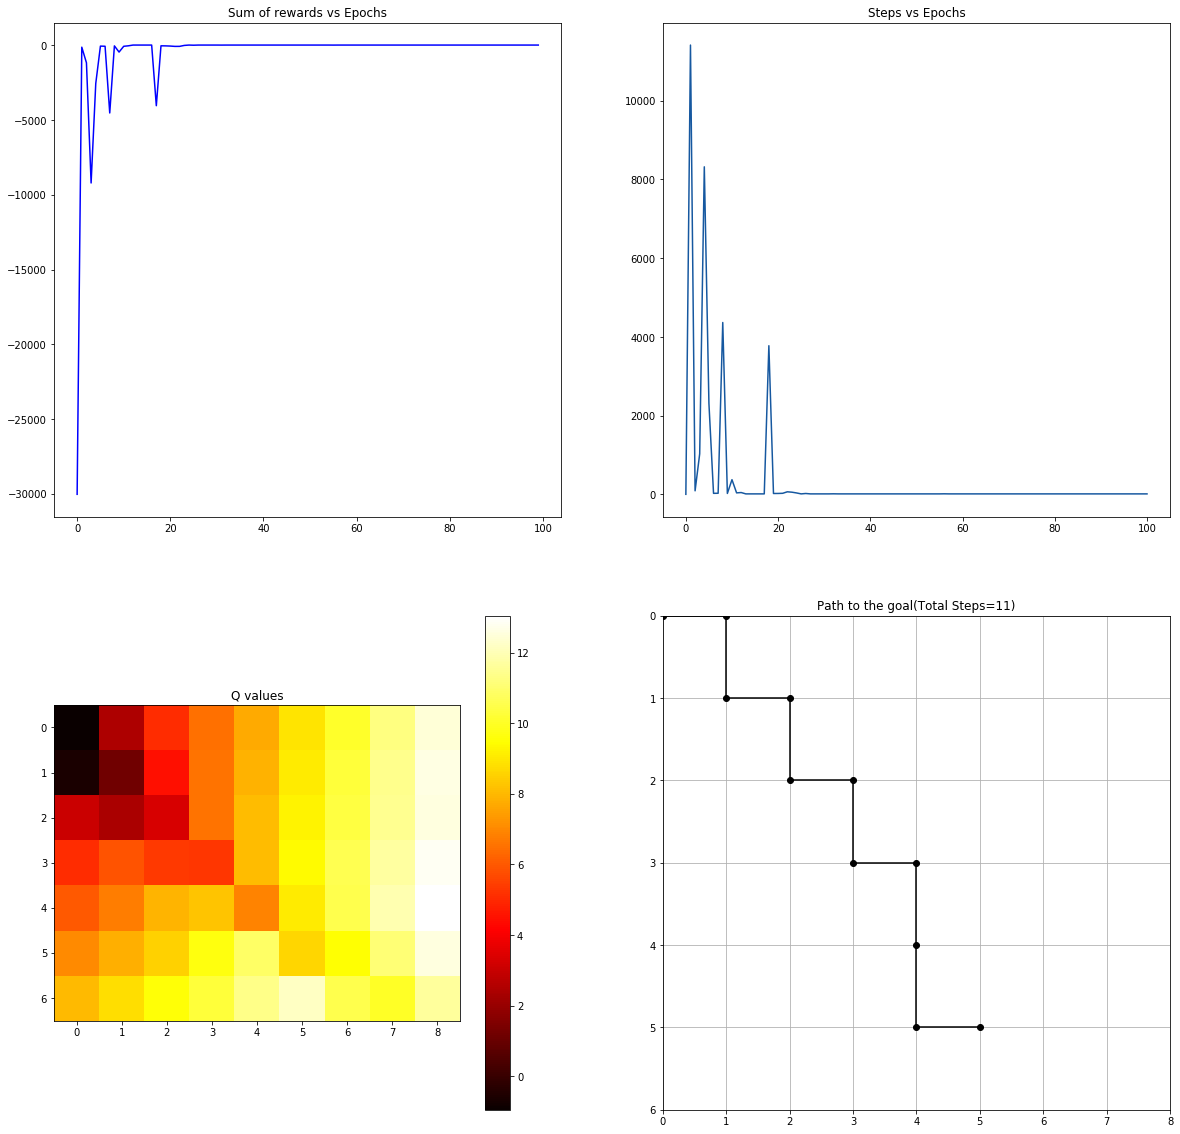

In [10]:
def plot_data(states,rewards,Q,steps):
    x=[]
    y=[]
    z=[]
    state_count=0
    for state in states:
        x.append(state[0])
        y.append(state[1])
        z.append(state_count)
        state_count=state_count+1
    
   
    f, ((ax1, ax2),(ax3,ax4))=plt.subplots(2, 2,figsize=(20,20))
    
    ax1.plot(rewards,marker='', color='blue')
    ax1.set_title("Sum of rewards vs Epochs")
    
    ax2.plot(steps,marker='', color='#1658a0')
    ax2.set_title("Steps vs Epochs")
    
    heatmap =ax3.imshow(Q, cmap='hot', interpolation='nearest')
    ax3.set_title("Q values")
    ax3.grid(False)
    
    f.colorbar(heatmap,ax=ax3)
    
    ax4.plot(x,y,marker='o', color='black')
    ax4.grid(True)
    ax4.axis([0, 8, 6, 0])
    title="Path to the goal(Total Steps="+str(len(states))+")"
    ax4.set_title(title)
    
plot_data(states,rewards,Q,steps)